In [14]:
############################################################------MODELISATION 3 BINAIRE-----####################################################################################################
#                                                                    
#                                                  Transformation de la variable cible en un modèle binaire 
#                                           où la valeur 1 correspond aux notes 1 et 2, et la valeur 2 aux notes 3, 4 et 5
#                                                           - Heatmap
#                                                           - Préparation des données à la modélisation
#                                                           - Modélisation : - RandomForestClassifier et LGBMClassifier
#                                                                            - Optimisation des hyperparametres
#                                                                            - Validation croisée
#                                                                            - Analyse des erreurs
#                                                                            - Interprétabilité                                                           
#                                                             
#############################################################################################################################################################################################

################################################ - IMPORTATION des bibliotheques - ##################################################

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
import re
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
#from imblearn.under_sampling import ClusterCentroid
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from scipy.sparse import csr_matrix
from scipy.sparse import hstack

import lightgbm as lgb
from lightgbm import LGBMClassifier
import shap
from sklearn.tree import plot_tree


In [ ]:
#################### ----Ne pas faire tourner tres long , utiliser le fichier ou sont stockés les resulats de cette partie ################################


############################################## - CREATION DES 2 nouvelles VARIABLES- #############################################################
##################################################################################################################################################

#____________________________________________________________________________________________________________________________________________________#
#                                                       
#                                                          Création "NBNEG" 
#                                        Nombre d’élèments de négation dans le titre du commentaire
#                                     
#_____________________________________________________________________________________________________________________________________________________#


#rajout de la negation non pris en compte precedement seult sur le titre


def custom_tokenize(text):
    # Compteur pour les négations
    negation_count = 0
    
    # Remplace les formes de négation par un symbole spécial et compter les occurrences
    def count_negation(match):
        nonlocal negation_count
        negation_count += 1
        return f'NEGATION_{match.group(1)}'
    
    # Mise à jour de l'expression régulière pour inclure "non"
    text = re.sub(r'\b(ne|n\'|pas|jamais|plus|non)\b', count_negation, text)
    
    # Tokenisation
    tokens1 = re.findall(r'\b\w+\b|NEGATION\w+', text)
    
    # Remplace le symbole spécial par le mot de négation
    tokensneg = [token.replace("NEGATION_", "") for token in tokens1]
    
    return tokens1, negation_count

# Applique la fonction à chaque ligne du DataFrame
def process_row(row):
    combined_text =  row['Titre_commentaire']
    #combined_text = row['Commentaire'] + " " + row['Titre_commentaire']
    tokens, negation_count = custom_tokenize(combined_text)
    
    # Détermine si le texte est négatif
    negatif = 1 if negation_count > 0 else 0  #negatif = oui=1
    
    return pd.Series([negatif, negation_count])

# Applique la fonction process_row à chaque ligne et créer de nouvelles colonnes
df[['negatif', 'nbneg']] = df.apply(process_row, axis=1)


#display(df.head())

#____________________________________________________________________________________________________________________________________________________#
#                                                       
#                                                          Création "SENTIMENT_DL" 
#                                       modèle BERT ("nlptown/bert-base-multilingual-uncased-sentiment")
#                                     Chaque commentaire, associé à son titre, est classé de 1 à 5 par ce modèle 
#_____________________________________________________________________________________________________________________________________________________#


# Étape 1 : Chargement du modèle et le tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# modèle en mode évaluation
model.eval()

# Étape 2 : Fonction pour prédire le sentiment
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():  # Pas besoin de calculer les gradients
        outputs = model(**inputs)
    logits = outputs.logits
    sentiment = torch.argmax(logits, dim=1).item()  # Obtenir l'indice de la classe avec la plus haute probabilité
    return sentiment+1    #modifier les classes de 1 à 5

# Étape 3 : Applique la fonction à chaque ligne du DataFrame
def process_row(row):
    combined_text = row['Commentaire'] + " " + row['Titre_commentaire']
    return predict_sentiment(combined_text)


df['sentiment_dl'] = df.apply(process_row, axis=1)

#display(df)

#############################################################- Sauvegarde une nouvelle base pour éviter de refaire tourner les varaible NLP -###################################
 
#df.to_csv(r"C:\Users\magal\Documents\Documents Magali\Formations\Formation machine learing\DataScientist\projet\code\derniere_base.csv", sep=';', index=False)

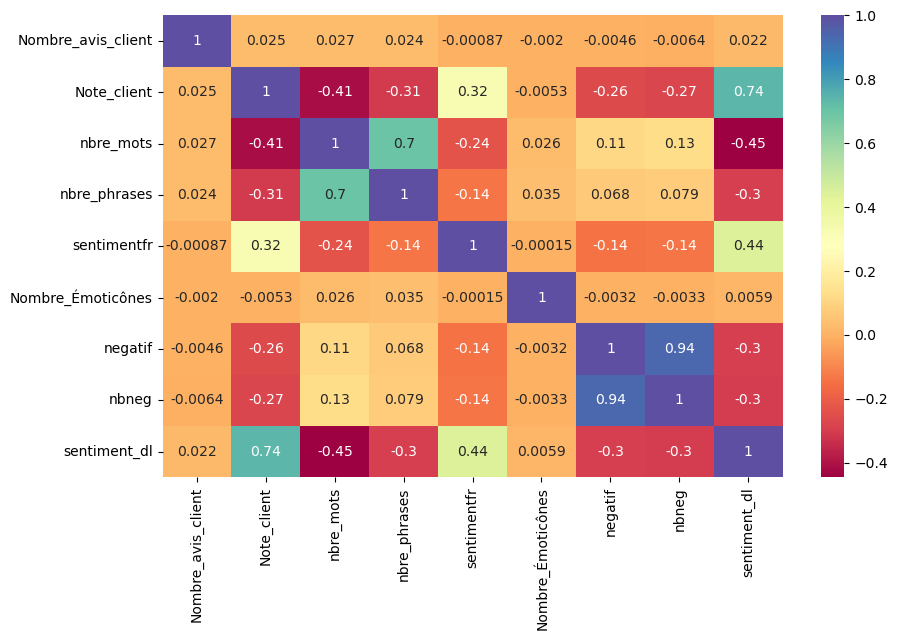

In [ ]:

############################################## - CREATION DE LA  VARIABLE BINAIRE- #############################################################
##################################################################################################################################################

#____________________________________________________________________________________________________________________________________________________#
#                                                       
#                                             Création de la variable Binaire
#                                           - la valeur 1 correspond aux notes 1 et 2
#                                           - la valeur 2 aux notes 3, 4 et 5
#                                     
#_____________________________________________________________________________________________________________________________________________________#


# Récup fichier sauvagarder avec le DataFrame compélté des 2 variables NLP
df=pd.read_csv(r"C:\Users\magal\Documents\Documents Magali\Formations\Formation machine learing\DataScientist\projet\code\derniere_base.csv", sep=';')

#Classification de la variable cible en variable binaire
df["Note_client"] = df["Note_client"].replace(to_replace=[1, 2, 3, 4, 5], value=[1, 1, 2, 2, 2])

#_____________________________visualisation avec une heatmap_______________________________

var_num = df.select_dtypes(include = ['int','float'])
#var_num=var_num.drop(["Nombre_avis_client","sentimentfr"], axis=1)

#corrélations de toutes les variables quantitatives de df.
cor = var_num.corr()
#print(cor)

fig = plt.subplots(figsize = (10,6))
sns.heatmap(cor, annot = True, cmap = "Spectral")
plt.show()


In [ ]:
###################################### - PREPARATION A LA MODELISATION- #########################################################
###################################################################################################################################


# Séparation l'ensemble d'entraînement, de validation et de test
X = df.drop(['Note_client',"Commentaire","Titre_commentaire","Nombre_avis_client","nbre_mots",'sentimentfr', 'Nombre_Émoticônes'],axis=1)
y = df['Note_client']


#Séparation des données en ensembles d'entraînement(80%), de validation(10%) et de test(10%)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

# Encodage indépendamment des 3 ensembles

X_numerique_train= X_train[["nbre_phrases","nbneg"]]
X_numerique_test= X_test[["nbre_phrases","nbneg"]]
X_numerique_val= X_val[["nbre_phrases","nbneg"]]

#X_numerique = df_train[['nbre_mots',"nbre_phrases" ,'sentimentfr', 'Nombre_Émoticônes']]

# Encodage la variable cible avec labelEncoder (pour des variables ordinales)

le = LabelEncoder()
y_train= le.fit_transform(y_train)+1
y_test = le.transform(y_test)+1
y_val= le.transform(y_val)+1


# Encodage des autres variables categorielles

X_categorielle_train=X_train[['class_longueur_mot',"class_pt_exclam","emoticones","class_nbavis","sentiment_dl","class_sentiment"]]  
X_categorielle_encoded_train = pd.get_dummies(X_categorielle_train, drop_first=True)
X_categorielle_encoded_train=X_categorielle_encoded_train.astype(int)


X_categorielle_test=X_test[['class_longueur_mot',"class_pt_exclam","emoticones","class_nbavis","sentiment_dl","class_sentiment"]]
X_categorielle_encoded_test = pd.get_dummies(X_categorielle_test, drop_first=True)
X_categorielle_encoded_test=X_categorielle_encoded_test.astype(int)

X_categorielle_val=X_val[['class_longueur_mot',"class_pt_exclam","emoticones","class_nbavis","sentiment_dl","class_sentiment"]]
X_categorielle_encoded_val = pd.get_dummies(X_categorielle_val, drop_first=True)
X_categorielle_encoded_val=X_categorielle_encoded_val.astype(int)


## Vectorisation sur les données textuelles

# Pour l'ensemble d'entraînement
vectorizer = TfidfVectorizer()
X_texte_train = X_train['Lemmes'] + ' ' + X_train['Lemmes_titre_commentaire']  # Combiner les colonnes texte
X_text_vectorized_train = vectorizer.fit_transform(X_texte_train)

# Pour l'ensemble de test
X_texte_test = X_test['Lemmes'] + ' ' + X_test['Lemmes_titre_commentaire']  # Combiner les colonnes texte
X_text_vectorized_test = vectorizer.transform(X_texte_test)  # Utilisez transform au lieu de fit_transform

# Pour l'ensemble de val
X_texte_val = X_val['Lemmes'] + ' ' + X_val['Lemmes_titre_commentaire']  # Combiner les colonnes texte
X_text_vectorized_val = vectorizer.transform(X_texte_val)  # Utilisez transform au lieu de fit_transform


# Transforme  en matrice creuse pour gagner du temps de calcul
X_categorielle_encoded_train_sparse = csr_matrix(X_categorielle_encoded_train)
X_numerique_train_sparse = csr_matrix(X_numerique_train)
X_text_vectorized_train_sparse = csr_matrix(X_text_vectorized_train)

X_numerique_val_sparse = csr_matrix(X_numerique_val)
X_categorielle_encoded_val_sparse = csr_matrix(X_categorielle_encoded_val)
X_text_vectorized_val_sparse = csr_matrix(X_text_vectorized_val)

X_numerique_test_sparse = csr_matrix(X_numerique_test)
X_categorielle_encoded_test_sparse = csr_matrix(X_categorielle_encoded_test)
X_text_vectorized_test_sparse = csr_matrix(X_text_vectorized_test)


# Combine les caractéristiques textuelles et numériques pour l'entraînement
X_train_combined = hstack([X_text_vectorized_train_sparse, X_categorielle_encoded_train_sparse, X_numerique_train_sparse])

#  pour les ensembles de validation et de test

X_val_combined = hstack([X_text_vectorized_val_sparse,X_categorielle_encoded_val_sparse, X_numerique_val_sparse])
X_test_combined = hstack([X_text_vectorized_test_sparse,X_categorielle_encoded_test_sparse, X_numerique_test_sparse])

# Normalisation des 3 ensembles
scaler = StandardScaler(with_mean=False)  # with_mean=False car TF-IDF peut avoir des valeurs nulles
X_train_scaled = scaler.fit_transform(X_train_combined)
X_val_scaled = scaler.transform(X_val_combined)
X_test_scaled = scaler.transform(X_test_combined)


# Reequilibrage avec SMOTE uniquement sur l'ensemble d'entraînement
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_train_equilibre, y_train_equilibre = smote.fit_resample(X_train_scaled, y_train)
print('Classes échantillon Oversampling SMOTE :', dict(pd.Series(y_train_equilibre).value_counts()))


#___________________    Partie pour analyser la coherence des resultats__________________________________________________________________________

# Récupération des indices de X_test pour relier avec le DataFrame d'origine
indices_test = X_test.index

# Récupération des notes du client à partir du DataFrame original pour les indices de X_test
notes_clients10 = df.loc[indices_test, 'Note_client'].values

 #Création d'un DataFrame avec les valeurs de y_test et les valeurs de X_test
df_test_results10 = pd.DataFrame({
    'Index': indices_test,
    'Predicted_Note_Client': y_test,
    'Note_Client_Original': notes_clients10 
})

# Ajout des colonnes de X_test au DataFrame
for column in X_test.columns:
    df_test_results10[column] = X_test[column].values

# Réinitialisation de l'index pour un affichage plus propre
df_test_results10.reset_index(drop=True, inplace=True)

# Affichage des résultats
print(df_test_results10.head())

#df_test_results10.to_csv(r"C:\Users\magal\Documents\Documents Magali\Formations\Formation machine learing\DataScientist\projet\code\verif.csv", sep=';', index=False, encoding='utf-8-sig')


In [19]:
####################################### - MODELISATION- ##########################################################################
###################################################################################################################################

#_______________________________ Modèle de classification RandomForestClassifier________________________________________________

# Initialise le modèle
modelf = RandomForestClassifier(random_state=42)

# Entraînement du modèle
modelf.fit(X_train_equilibre, y_train_equilibre)

# Prédictions sur l'ensemble du test
y_test_pred = modelf.predict(X_test_scaled)

# Prédictions sur l'ensemble de validation


# Évaluation du modèle
print("Classification Report sur l'ensemble de test:\n", classification_report(y_test, y_test_pred))
print("Accuracy sur l'ensemble de test:", accuracy_score(y_test, y_test_pred))
cmsm = pd.crosstab(y_test, y_test_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
display(cmsm)
print("----------------------------")

# print("Classification Report sur l'ensemble de validation:\n", classification_report(y_val, y_val_pred))
# print("Accuracy sur l'ensemble de validation:", accuracy_score(y_val, y_val_pred))

Classification Report sur l'ensemble de test:
               precision    recall  f1-score   support

           1       0.85      0.68      0.76       319
           2       0.97      0.99      0.98      3038

    accuracy                           0.96      3357
   macro avg       0.91      0.83      0.87      3357
weighted avg       0.96      0.96      0.96      3357

Accuracy sur l'ensemble de test: 0.958593982722669


Classe prédite,1,2
Classe réelle,,
1,217,102
2,37,3001


----------------------------


In [9]:
# ___________________________Modèle de classification LightGBM_______________________________________________________

# Initialise le modèle
model = LGBMClassifier()

# Entraînement du modèle
model.fit(X_train_equilibre, y_train_equilibre)

# Prédictions sur l'ensemble du test
y_test_pred = model.predict(X_test_scaled)

# Prédictions sur l'ensemble de validation

# Évaluation du modèle
print("Classification Report sur l'ensemble de test:\n", classification_report(y_test, y_test_pred))
print("Accuracy sur l'ensemble de test:", accuracy_score(y_test, y_test_pred))
cmsm = pd.crosstab(y_test, y_test_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
display(cmsm)
print("----------------------------")

c:\Users\magal\anaconda3\envs\projet\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\magal\anaconda3\envs\projet\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\magal\anaconda3\envs\projet\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\magal\anaconda3\envs\projet\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\magal\anaconda3\envs\projet\Lib\subprocess.py", line 1538, in _

[LightGBM] [Info] Number of positive: 24300, number of negative: 24300
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 237959
[LightGBM] [Info] Number of data points in the train set: 48600, number of used features: 4652
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Classification Report sur l'ensemble de test:
               precision    recall  f1-score   support

           1       0.82      0.78      0.80       319
           2       0.98      0.98      0.98      3038

    accuracy                           0.96      3357
   macro avg       0.90      0.88      0.89      3357
weighted avg       0.96      0.96      0.96      3357

Accuracy sur l'ensemble de test: 0.9624664879356568


Classe prédite,1,2
Classe réelle,,
1,249,70
2,56,2982


----------------------------


In [ ]:

#_______________________équilibrer les classe avec des poids____________________________________________
#  
# import numpy as np
# import pandas as pd
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, accuracy_score
# import lightgbm as lgb
# from lightgbm import LGBMClassifier

# # classes 1, 2, 3, 4, 5
# classes = np.array([1, 2, 3, 4, 5])

# # Calculer les poids de classe
# class_weights = compute_class_weight('balanced', classes=classes, y=y_train_equilibre)
# class_weight_dict = dict(zip(classes, class_weights))

# # Initialiser le modèle avec les poids de classe
# model = LGBMClassifier(class_weight=class_weight_dict)

# # Entraînement du modèle
# model.fit(X_train_equilibre, y_train_equilibre)

# # Prédictions sur l'ensemble du test
# y_test_pred = model.predict(X_test_scaled)

# # Évaluation du modèle
# print("Classification Report sur l'ensemble de test:\n", classification_report(y_test, y_test_pred))
# print("Accuracy sur l'ensemble de test:", accuracy_score(y_test, y_test_pred))
# cmsm = pd.crosstab(y_test, y_test_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
# display(cmsm)
# print("----------------------------")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.390958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 402531
[LightGBM] [Info] Number of data points in the train set: 98585, number of used features: 7352
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
Classification Report sur l'ensemble de test:
               precision    recall  f1-score   support

           1       0.68      0.86      0.76       244
           2       0.29      0.11      0.16        75
           3       0.39      0.28      0.33       130
           4       0.51      0.30      0.38       443
           5       0.89      0.96      0.92      2465



Classe prédite,1,2,3,4,5
Classe réelle,,,,,
1,211,5,13,6,9
2,41,8,16,9,1
3,31,11,37,37,14
4,10,3,21,134,275
5,16,1,9,76,2363


----------------------------


In [10]:

#__________________________Optimisation pour modele LGBMClassifier_____________________________________

# Initialise le modèle
model = LGBMClassifier()

# Grille des hyperparamètres à tester (réduite)
param_dist = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 200],
}

# Initialise le RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                   scoring='accuracy', cv=2, n_iter=10, verbose=1, n_jobs=-1)

# Entraînement du modèle avec recherche des meilleurs hyperparamètres
random_search.fit(X_train_equilibre, y_train_equilibre)

# Affiche les meilleurs hyperparamètres
print("Meilleurs hyperparamètres trouvés : ", random_search.best_params_)

# Prédictions sur l'ensemble de test avec le meilleur modèle
y_test_pred = random_search.predict(X_test_scaled)

# Évaluation du modèle
print("Classification Report sur l'ensemble de test:\n", classification_report(y_test, y_test_pred))
print("Accuracy sur l'ensemble de test:", accuracy_score(y_test, y_test_pred))
cmsm = pd.crosstab(y_test, y_test_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
display(cmsm)
print("----------------------------")


Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 24300, number of negative: 24300
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237959
[LightGBM] [Info] Number of data points in the train set: 48600, number of used features: 4652
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Meilleurs hyperparamètres trouvés :  {'num_leaves': 50, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.05}
Classification Report sur l'ensemble de test:
               precision    recall  f1-score   support

           1       0.81      0.79      0.80       319
           2       0.98      0.98      0.98      3038

    accuracy                           0.96      3357
   macro avg       0.89      0.88      0.89      3357
weighted avg       0.96      0.96      0.96      3357

Accur

Classe prédite,1,2
Classe réelle,,
1,251,68
2,58,2980


----------------------------


In [11]:
# ____________________Validation croisée LightGBM________________________________

from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(random_search, X_train_equilibre, y_train_equilibre, cv=5, scoring='accuracy')

print("Scores de validation croisée : ", cv_scores)
print("Moyenne des scores de validation croisée : ", cv_scores.mean())

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 19440, number of negative: 19440
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 199414
[LightGBM] [Info] Number of data points in the train set: 38880, number of used features: 4068
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 19440, number of negative: 19440
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200333
[LightGBM] [Info] Number of data points in the train set: 38880, number of used features: 4073
[LightG

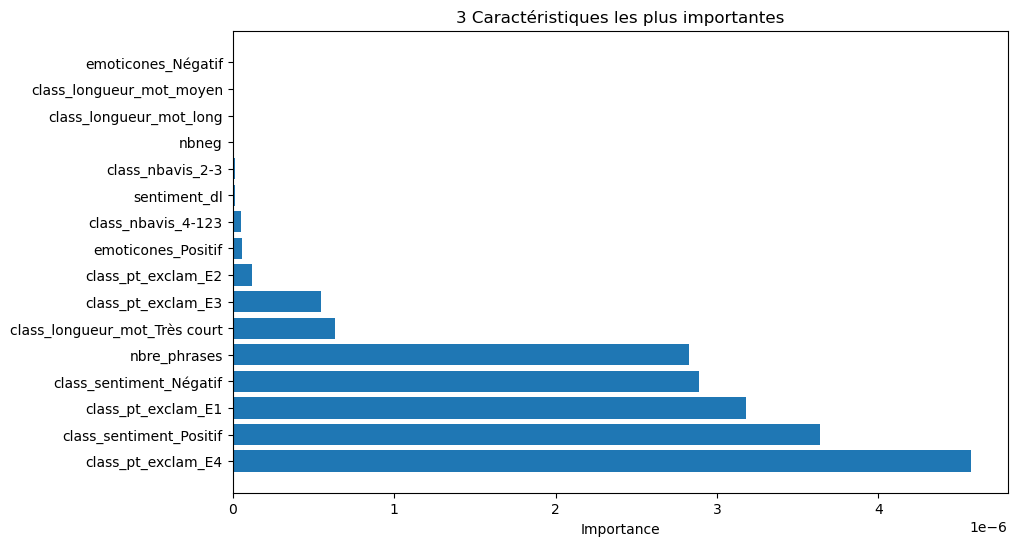

In [34]:
##_________________________Interprétabilité du modele__________________________________


# # Récupérer les importances des caractéristiques
# importances = modelf.feature_importances_

# # Récupérer les noms des caractéristiques
# cat_feature_names = X_categorielle_encoded_train.columns  # Pour les caractéristiques catégorielles
# num_feature_names = X_numerique_train.columns  # Pour les caractéristiques numériques
# text_feature_names = vectorizer.get_feature_names_out()  # Pour les caractéristiques textuelles

# # Créer une liste des noms de caractéristiques combinées
# combined_feature_names = np.concatenate([cat_feature_names, num_feature_names, text_feature_names])

# # Créer un DataFrame pour l'importance des caractéristiques
# feat_importances = pd.DataFrame({'Feature': combined_feature_names, 'Importance': importances})
# feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

# # Afficher les 10 caractéristiques les plus importantes
# plt.figure(figsize=(10, 6))
# plt.barh(feat_importances['Feature'][:10], feat_importances['Importance'][:10])
# plt.xlabel('Importance')
# plt.title('10 Caractéristiques les plus importantes')
# plt.gca().invert_yaxis()  # Inverser l'axe y pour afficher la plus importante en haut
# plt.show()


# sans les données textuelles 
 # les importances des caractéristiques
importances = modelf.feature_importances_

# les noms des caractéristiques
cat_feature_names = X_categorielle_encoded_train.columns  # Pour les caractéristiques catégorielles
num_feature_names = X_numerique_train.columns  # Pour les caractéristiques numériques

# Liste des noms de caractéristiques combinées (uniquement catégorielles et numériques)
combined_feature_names = np.concatenate([cat_feature_names, num_feature_names])

# Créer un DataFrame pour l'importance des caractéristiques

selected_importances = importances[:len(combined_feature_names)]

feat_importances = pd.DataFrame({'Feature': combined_feature_names, 'Importance': selected_importances})
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

# Afficher les 3 caractéristiques les plus importantes
plt.figure(figsize=(10, 6))
plt.barh(feat_importances['Feature'][:25], feat_importances['Importance'][:25])
plt.xlabel('Importance')
plt.title('3 Caractéristiques les plus importantes')
plt.show()


In [ ]:
########################################### Trop long à s'executer ####################################

# import shap

# # Créer un explainer SHAP
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_train_equilibre)

# # Visualiser les valeurs SHAP
# shap.summary_plot(shap_values, X_train_equilibre)

In [21]:
#___________________________________________A executer si seulement c'est le meilleur modele__________________________________________

# ________________________Optimisation des hyperparamètres avec GridSearchCV pour le modele RandomForestClassifier____________

# Initialise le modèle
model = RandomForestClassifier()

# Grille des hyperparamètres à tester 
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_equilibre, y_train_equilibre)

print("Meilleurs hyperparamètres :", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Entraînement du modèle optimisé sur les données rééquilibrées
best_model.fit(X_train_equilibre, y_train_equilibre)

# Prédictions sur l'ensemble de validation
y_val_pred = best_model.predict(X_val_scaled)

# Évaluation du modèle
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

# Évaluation du modèle
print("Classification Report sur l'ensemble de validation:\n", classification_report(y_val, y_val_pred))
print("Accuracy sur l'ensemble de validation:", accuracy_score(y_val, y_val_pred))
cmsm = pd.crosstab(y_val, y_val_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
display(cmsm)
print("----------------------------")

Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\magal\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Meilleurs hyperparamètres : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
[[ 154    1    3    5   90]
 [  31    2    3    6   34]
 [  14    1    8   17   96]
 [  12    1    7   49  358]
 [  10    0    3   45 2406]]
              precision    recall  f1-score   support

           1       0.70      0.61      0.65       253
           2       0.40      0.03      0.05        76
           3       0.33      0.06      0.10       136
           4       0.40      0.11      0.18       427
           5       0.81      0.98      0.88      2464

    accuracy                           0.78      3356
   macro avg       0.53      0.36      0.37      3356
weighted avg       0.72      0.78      0.73      3356

Classification Report sur l'ensemble de validation:
               precision    recall  f1-score   support

           1       0.70      0.61      0.65       253
           2       0.40      0.03      0.05        76
           3       0.33      0.06      

Classe prédite,1,2,3,4,5
Classe réelle,,,,,
1,154,1,3,5,90
2,31,2,3,6,34
3,14,1,8,17,96
4,12,1,7,49,358
5,10,0,3,45,2406


----------------------------


In [8]:
#########################################- Partie VERIFICATION- ##########################################
##########################################################################################################

# Récupération des indices de X_test pour relier avec le DataFrame d'origine
indices_test2 = X_test.index

# Récupération des notes du client à partir du DataFrame original pour les indices de X_test
notes_clients102 = df.loc[indices_test, 'Note_client'].values
Lemmes102 = df.loc[indices_test, 'Lemmes'].values
nbre_phrases102=df.loc[indices_test, 'nbre_phrases'].values
Lemmes_titre_commentaire102 = df.loc[indices_test, 'Lemmes_titre_commentaire'].values
class_longueur_mot02=df.loc[indices_test, 'class_longueur_mot'].values
class_pt_exclam102 = df.loc[indices_test, 'class_pt_exclam'].values
class_sentiment102 = df.loc[indices_test, 'class_sentiment'].values
emoticones102=df.loc[indices_test, 'emoticones'].values
sentimentfr102 = df.loc[indices_test, 'sentimentfr'].values
sentimentdl102 = df.loc[indices_test, 'sentiment_dl'].values
nbneg102 = df.loc[indices_test, 'nbneg'].values
negatif102 = df.loc[indices_test, 'negatif'].values

 #Création d'un DataFrame avec les valeurs de y_test et les valeurs de X_test
df_test_results102 = pd.DataFrame({
    'Index': indices_test,
    'classe reelle': y_test,
    'Classe prédite': y_test_pred,
    'Note_Client_Original': notes_clients102,
    'Lemmes': Lemmes102,
    'Lemmes_titre_commentaire': Lemmes_titre_commentaire102,
    'Nombre_de_phrases': nbre_phrases102,
    'Classe_longueur_mot': class_longueur_mot02,
    'Classe_pt_exclam': class_pt_exclam102,
    'Classe_sentiment': class_sentiment102,
    'Emoticones': emoticones102,
    'Sentimentfr': sentimentfr102,
    "nombre neg": nbneg102,
    "negatif": negatif102,
    "sentiment":sentimentdl102 
})
# Ajout des colonnes de X_test au DataFrame
for column in X_test.columns:
    df_test_results10[column] = X_test[column].values

# Réinitialisation de l'index pour un affichage plus propre
df_test_results102.reset_index(drop=True, inplace=True)

# Affichage des résultats
display(df_test_results102.head())


,Index,classe reelle,Classe prédite,Note_Client_Original,Lemmes,Lemmes_titre_commentaire,Nombre_de_phrases,Classe_longueur_mot,Classe_pt_exclam,Classe_sentiment,Emoticones,Sentimentfr,nombre neg,negatif,sentiment
0,7506,2,2,2,"['matériel', 'conforme', 'commande', 'service'...",[],1,Court,E0,Positif,Neutre,0.328000,0,0,5
1,27833,1,1,1,"['voil', 'bient', 'mois', 'commandé', 'apple',...","['deuxi', 'commande', 'toujours', 'colis']",4,long,E3,Positif,Neutre,0.029792,1,1,1
2,31923,1,1,1,"['achat', 'effectué', 'jours', 'livraison', 'p...",['éviter'],5,long,E1,Négatif,Neutre,-0.050000,0,0,1
3,11723,2,2,2,"['procédure', 'remplacement', 'identique', 'pu...","['procédure', 'remplacement']",1,long,E0,Neutre,Neutre,0.000000,0,0,3
4,4348,2,2,2,"['site', 'clair', 'données', 'compl', 'achat',...","['site', 'clair', 'données', 'compl', 'pour']",1,moyen,E0,Positif,Neutre,0.270000,0,0,5


Analyse des erreurs :
      Réel  Prédiction  Erreur
23       2           1    True
36       1           2    True
74       1           2    True
75       1           2    True
81       1           2    True
...    ...         ...     ...
3210     2           1    True
3263     1           2    True
3302     2           1    True
3349     1           2    True
3354     1           2    True

[126 rows x 3 columns]


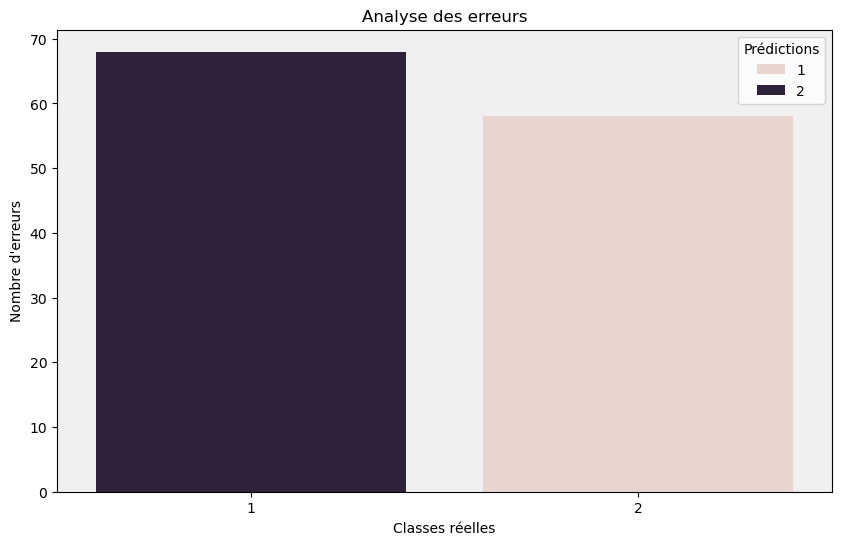

In [11]:
#__________________________graph des erreurs___________________________________________________


# Analyse des erreurs
errors = pd.DataFrame({'Réel': y_test, 'Prédiction': y_test_pred})
errors['Erreur'] = errors['Réel'] != errors['Prédiction']
error_analysis = errors[errors['Erreur']]

print("Analyse des erreurs :")
print(error_analysis)

# Representation graphique des erreurs
plt.figure(figsize=(10, 6))
sns.countplot(x='Réel', hue='Prédiction', data=error_analysis)
# Ajout un fond gris clair
plt.gca().set_facecolor('#f0f0f0')
plt.title("Analyse des erreurs")
plt.xlabel("Classes réelles")
plt.ylabel("Nombre d'erreurs")
plt.legend(title='Prédictions')
plt.show()

In [ ]:
#_____________________________Analyse des erreurs______________________________________________

# DataFrame avec les valeurs réelles et prédites
results_df = pd.DataFrame({
    'Classe réelle': y_test,
    'Classe prédite': y_test_pred
})

 #Filtrer les erreurs de prédiction
errors_df = results_df[results_df['Classe réelle'] != results_df['Classe prédite']]

# Afficher les lignes avec des erreurs de prédiction
print("Lignes avec des erreurs de prédiction :")
print(errors_df)

# Ajouter une colonne d'index pour pouvoir joindre avec le DataFrame d'origine
errors_df = errors_df.reset_index()

# Joindre avec le DataFrame d'origine en utilisant l'index ou une clé unique
# Assumons que original_df a un index qui correspond à celui de results_df
# Si ce n'est pas le cas, vous devrez utiliser une colonne clé appropriée.
errors_full_df = errors_df.merge(df, left_on='index', right_index=True, suffixes=('_erreur', '_original'))

# Afficher les lignes avec des erreurs de prédiction complétées par les données d'origine
print("Lignes avec des erreurs de prédiction :")
display(errors_full_df)